# 1. Read data and basic setup.

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np

from scipy.signal import savgol_filter
import statsmodels.api as sm
#import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations

import matplotlib.pyplot as plt

# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,6)})

Read in the data, compute standard numeric stats from some of the string variables, and check the head.

In [3]:
# read the data
data = pd.read_csv('nfl_team_stats_2002-2021.csv')

data['score_diff'] = data['score_home'] - data['score_away']

data['winner'] = (data['score_home'] - data['score_away'])>0
data['winner'] = data['winner'].astype(int)

# split string info for third and fourth down attmepts to float succeses and rate
third_downs_away = data['third_downs_away'].str.split('-', expand=True)
data['third_downs_away'] = third_downs_away[0].to_numpy(dtype=int)
data['third_downs_rate_away'] = np.nan_to_num(third_downs_away[0].to_numpy(dtype=float)/third_downs_away[1].to_numpy(dtype=float), nan=0.0)
data['third_downs_attempts_away'] = third_downs_away[1].to_numpy(dtype=int)

third_downs_home = data['third_downs_home'].str.split('-', expand=True)
data['third_downs_home'] = third_downs_home[0].to_numpy(dtype=float)
data['third_downs_rate_home'] = np.nan_to_num(third_downs_home[0].to_numpy(dtype=float)/third_downs_home[1].to_numpy(dtype=float), nan=0.0)
data['third_downs_attempts_home'] = third_downs_home[1].to_numpy(dtype=float)

# split string info for third and fourth down attmepts to float succeses and rate
fourth_downs_away = data['fourth_downs_away'].str.split('-', expand=True)
data['fourth_downs_away'] = fourth_downs_away[0].to_numpy(dtype=int)
data['fourth_downs_rate_away'] = np.nan_to_num(fourth_downs_away[0].to_numpy(dtype=float)/fourth_downs_away[1].to_numpy(dtype=float), nan=0.0)
data['fourth_downs_attempts_away'] = fourth_downs_away[1].to_numpy(dtype=int)

fourth_downs_home = data['fourth_downs_home'].str.split('-', expand=True)
data['fourth_downs_home'] = third_downs_home[0].to_numpy(dtype=float)
data['fourth_downs_rate_home'] = np.nan_to_num(third_downs_home[0].to_numpy(dtype=float)/third_downs_home[1].to_numpy(dtype=float), nan=0.0)
data['fourth_downs_attempts_home'] = third_downs_home[1].to_numpy(dtype=float)

# split string info for completions to float succeses and rate
comp_att_away = data['comp_att_away'].str.split('-', expand=True)
data['complete_passes_away'] = comp_att_away[0].to_numpy(dtype=int)
data['pass_completion_rate_away'] = np.nan_to_num(comp_att_away[0].to_numpy(dtype=float)/comp_att_away[1].to_numpy(dtype=float), nan=0.0)
data['pass_attempt_away'] = comp_att_away[1].to_numpy(dtype=int)
data.drop('comp_att_away',1, inplace=True)

comp_att_home = data['comp_att_home'].str.split('-', expand=True)
data['complete_passes_home'] = comp_att_home[0].to_numpy(dtype=int)
data['pass_completion_rate_home'] = np.nan_to_num(comp_att_home[0].to_numpy(dtype=float)/comp_att_home[1].to_numpy(dtype=float), nan=0.0)
data['pass_attempt_home'] = comp_att_home[1].to_numpy(dtype=int)
data.drop('comp_att_home',1, inplace=True)

# split string info for sacks to float succeses and rate
sacks_away = data['sacks_away'].str.split('-', expand=True)
data['sacks_away'] = sacks_away[0].to_numpy(dtype=int)
data['pressures_away'] = sacks_away[1].to_numpy(dtype=int)

sacks_home = data['sacks_home'].str.split('-', expand=True)
data['sacks_home'] = sacks_home[0].to_numpy(dtype=int)
data['pressures_home'] = sacks_home[1].to_numpy(dtype=int)

# split string info for penalties to float succeses and rate
penalties_away = data['penalties_away'].str.split('-', expand=True)
data['penalties_away'] = np.nan_to_num(penalties_away[0].to_numpy(dtype=int), nan=0.0)
data['penalties_yards_away'] = np.nan_to_num(penalties_away[1].to_numpy(dtype=int), nan=0.0)

penalties_home = data['penalties_home'].str.split('-', expand=True)
data['penalties_home'] = np.nan_to_num(penalties_home[0].to_numpy(dtype=int), nan=0.0)
data['penalties_yards_home'] = np.nan_to_num(penalties_home[1].to_numpy(dtype=int), nan=0.0)

# split string info for completions to float succeses and rate
redzone_away = data['redzone_away'].str.split('-', expand=True)
data['redzone_sucess_away'] = redzone_away[0].to_numpy(dtype=int)
data['redzone_rate_away'] = np.nan_to_num(redzone_away[0].to_numpy(dtype=float)/redzone_away[1].to_numpy(dtype=float), nan=0.0)
data['redzone_attempts_away'] = redzone_away[1].to_numpy(dtype=int)
data.drop('redzone_away',1, inplace=True)

redzone_home = data['redzone_home'].str.split('-', expand=True)
data['redzone_sucess_home'] = redzone_home[0].to_numpy(dtype=int)
data['redzone_rate_home'] = np.nan_to_num(redzone_home[0].to_numpy(dtype=float)/redzone_home[1].to_numpy(dtype=float), nan=0.0)
data['redzone_attempts_home'] = redzone_home[1].to_numpy(dtype=int)
data.drop('redzone_home',1, inplace=True)

# split string info for completions to float succeses and rate
possession_away = data['possession_away'].str.split(':', expand=True)
data['possession_away'] = possession_away[0].to_numpy(dtype=float) * 60 + possession_away[1].to_numpy(dtype=float)

possession_home = data['possession_home'].str.split(':', expand=True)
data['possession_home'] = possession_home[0].to_numpy(dtype=float) * 60 + possession_home[1].to_numpy(dtype=float)

day_numbers = pd.to_numeric((pd.to_datetime(data['date']) - pd.to_datetime(data['date'][0])).dt.days,
                            downcast='integer')
years = np.ones(len(day_numbers))*2002
for idx in range(1,len(day_numbers)):
    years[idx] = years[idx-1] + ((day_numbers[idx]-day_numbers[idx-1]) > 30)*1
data['season'] = years
    
# get basic info
nRows = data.shape[0]
nCols = data.shape[1]
column_names = list(data.columns)

# display the head
data.head()

/tmp/ipykernel_23080/232502689.py:23: RuntimeWarning: invalid value encountered in true_divide
  data['fourth_downs_rate_away'] = np.nan_to_num(fourth_downs_away[0].to_numpy(dtype=float)/fourth_downs_away[1].to_numpy(dtype=float), nan=0.0)
/tmp/ipykernel_23080/232502689.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop('comp_att_away',1, inplace=True)
/tmp/ipykernel_23080/232502689.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop('comp_att_home',1, inplace=True)
/tmp/ipykernel_23080/232502689.py:65: RuntimeWarning: invalid value encountered in true_divide
  data['redzone_rate_away'] = np.nan_to_num(redzone_away[0].to_numpy(dtype=float)/redzone_away[1].to_numpy(dtype=float), nan=0.0)
/tmp/ipykernel_23080/232502689.py:67: FutureWarning: In a future version of pandas all arguments of DataFra

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,sacks_away,sacks_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,penalties_away,penalties_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,score_diff,winner,third_downs_rate_away,third_downs_attempts_away,third_downs_rate_home,third_downs_attempts_home,fourth_downs_rate_away,fourth_downs_attempts_away,fourth_downs_rate_home,fourth_downs_attempts_home,complete_passes_away,pass_completion_rate_away,pass_attempt_away,complete_passes_home,pass_completion_rate_home,pass_attempt_home,pressures_away,pressures_home,penalties_yards_away,penalties_yards_home,redzone_sucess_away,redzone_rate_away,redzone_attempts_away,redzone_sucess_home,redzone_rate_home,redzone_attempts_home,season
0,2002-09-05,49ers,Giants,13,21,4,9.0,0,9.0,166,318,113,43,279,361,0,3,25,22,0,0,1,3,1,3,5,10,13,15,0,0,1652.0,1948.0,16,13,-3,0,0.333333,12,0.562500,16.0,0.0,0,0.562500,16.0,16,0.615385,26,28,0.622222,45,0,24,29,80,0,0.0,8,0,0.0,6,2002.0
1,2002-09-08,Jets,Bills,18,26,2,7.0,0,7.0,193,242,73,142,266,384,3,4,14,32,1,1,0,2,1,3,10,10,17,18,2,0,1266.0,2348.0,37,31,-6,0,0.250000,8,0.411765,17.0,0.0,0,0.411765,17.0,24,0.800000,30,26,0.666667,39,17,29,90,82,0,0.0,9,0,0.0,8,2002.0
2,2002-09-08,Vikings,Bears,19,20,5,7.0,0,7.0,228,288,140,80,368,368,1,1,33,26,1,1,2,1,3,2,8,4,17,17,0,0,1891.0,1709.0,23,27,4,1,0.384615,13,0.538462,13.0,0.0,0,0.538462,13.0,16,0.571429,28,20,0.606061,33,6,9,52,33,0,0.0,7,0,0.0,6,2002.0
3,2002-09-08,Chargers,Bengals,27,13,6,4.0,0,4.0,160,167,241,36,401,203,1,4,45,13,0,0,0,1,0,1,4,9,11,15,0,0,2268.0,1332.0,34,6,-28,0,0.600000,10,0.363636,11.0,0.0,0,0.363636,11.0,15,0.789474,19,18,0.580645,31,0,31,39,57,0,0.0,7,0,0.0,5,2002.0
4,2002-09-08,Chiefs,Browns,24,24,5,4.0,0,4.0,276,352,194,59,470,411,0,1,30,20,0,1,1,0,1,1,9,4,20,17,0,0,1816.0,1784.0,40,39,-1,0,0.454545,11,0.363636,11.0,0.0,0,0.363636,11.0,20,0.689655,29,28,0.700000,40,0,7,87,38,0,0.0,10,0,0.0,10,2002.0


In [4]:
# check that there are no NaNs
data.columns[data.isna().any()].tolist()

[]

Check the data types.

In [5]:
data.dtypes

date                      object
away                      object
home                      object
first_downs_away           int64
first_downs_home           int64
                          ...   
redzone_attempts_away      int64
redzone_sucess_home        int64
redzone_rate_home        float64
redzone_attempts_home      int64
season                   float64
Length: 62, dtype: object

# 2. Exploratory Data Analysis for the initial data frame

Create a scatterplot to get peak at a relationship that should be meaningful - score_home as a function of total_yards_home, colored by whether the home team won (winner=1) or not (winner=0)

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


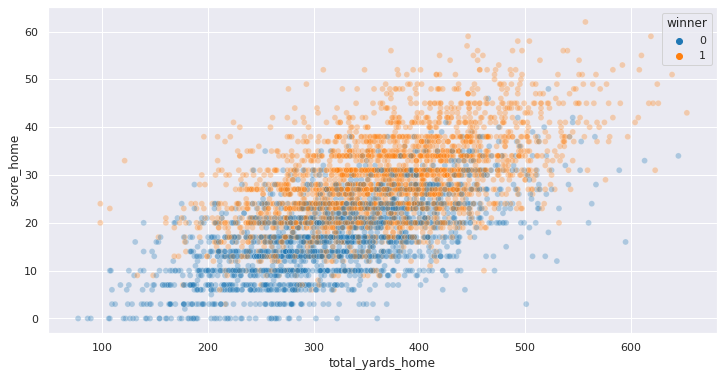

In [6]:
# simple scatter plot
sns.scatterplot(data['total_yards_home'],data['score_home'],alpha=0.3, hue=data["winner"], palette="tab10");

Check the regression line for this relationship.

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


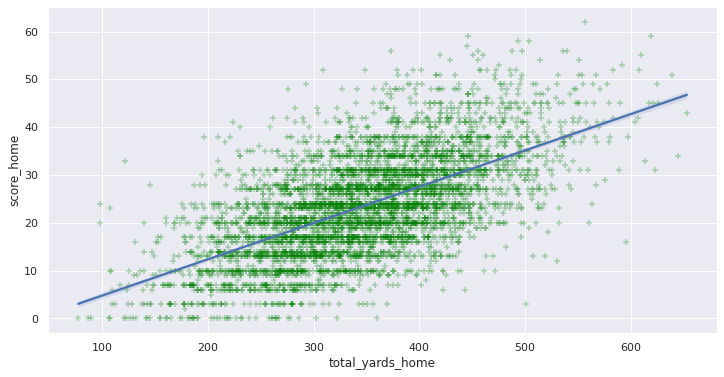

In [7]:
# scatterplot with regression line
sns.regplot(data['total_yards_home'],data['score_home'], marker="+", scatter_kws={'alpha':0.3, 'color':'green'});

Plot data precentiles for the score as a function of the yards for the home team.

In [8]:
def bin_by(x, y, nbins=30, bins = None):
    """
    Divide the x axis into sections and return groups of y based on its x value
    """
    if bins is None:
        bins = np.linspace(x.min(), x.max(), nbins)

    bin_space = (bins[-1] - bins[0])/(len(bins)-1)/2

    indicies = np.digitize(x, bins + bin_space)

    output = []
    for i in range(0, len(bins)):
        output.append(y[indicies==i])
    #
    # prepare a dataframe with cols: median; mean; 1up, 1dn, 2up, 2dn, 3up, 3dn
    df_names = ['mean', 'median', '5th', '95th', '10th', '90th', '25th', '75th']
    df = pd.DataFrame(columns = df_names)
    to_delete = []
    # for each bin, determine the std ranges
    for y_set in output:
        if y_set.size > 0:
            av = y_set.mean()
            intervals = np.percentile(y_set, q = [50, 5, 95, 10, 90, 25, 75])
            res = [av] + list(intervals)
            df = df.append(pd.DataFrame([res], columns = df_names))
        else:
            # just in case there are no elements in the bin
            to_delete.append(len(df) + 1 + len(to_delete))
            

    # add x values
    bins = np.delete(bins, to_delete)
    df['x'] = bins

    return df

def custom_percentile_plot(data, x_var, y_var, nbins):
    # generate random variables
    x,y = data[x_var],data[y_var]

    # bin the values and determine the envelopes
    df = bin_by(x, y, nbins=nbins, bins = None)

    # determine the colors
    cols = ['#EE7550', '#F19463', '#F6B176']

    with plt.style.context('fivethirtyeight'): 
        # plot the 3rd stdv
        plt.fill_between(df.x, df['5th'], df['95th'], alpha=0.7,color = cols[2])
        plt.fill_between(df.x, df['10th'], df['90th'], alpha=0.7,color = cols[1])
        plt.fill_between(df.x, df['25th'], df['75th'], alpha=0.7,color = cols[0])
        # plt the line
        plt.plot(df.x, df['median'], color = '1', alpha = 0.7, linewidth = 1)
        # plot the points
        plt.scatter(x, y, facecolors='white', edgecolors='0', s = 5, lw = 0.7)
        plt.title('Percenile Plot (90%, 80%, and 50%)')
        plt.xlabel(x_var)
        plt.ylabel(y_var)

    plt.savefig('fig1.png', facecolor='white', edgecolor='none')
    plt.show()

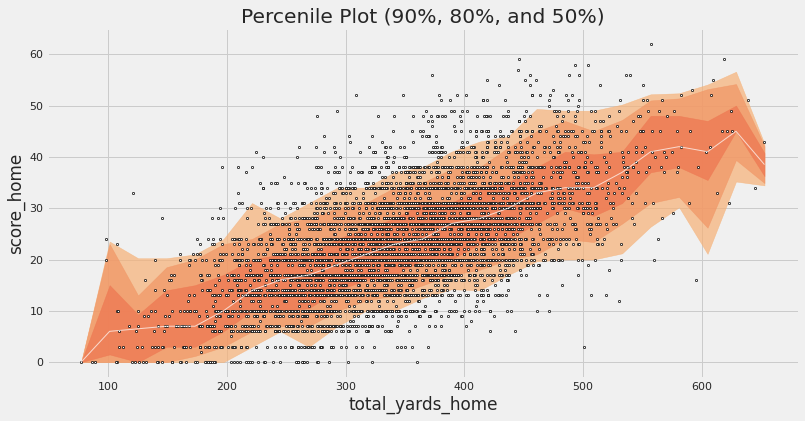

In [9]:
custom_percentile_plot(data, 'total_yards_home', 'score_home', 25)

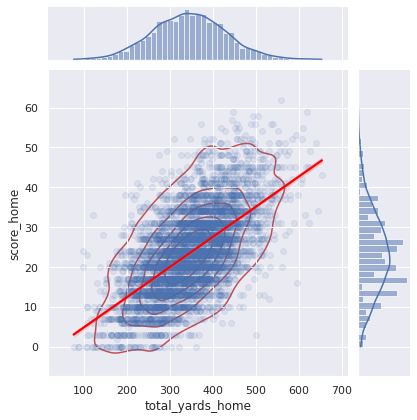

In [10]:
# jointplot, with both histograms and regression line in red
g = sns.jointplot(x=data['total_yards_home'], y=data['score_home'], kind='reg',
                  joint_kws={'line_kws':{'color':'red'}}, scatter_kws={'alpha':0.1}); 
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6);

In [11]:
# make a linear regreesion model to predict the hom team score
model = sm.OLS(data['score_home'], data[['total_yards_home','total_yards_away']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             score_home   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                          2.370e+04
Date:                Tue, 11 Oct 2022   Prob (F-statistic):                        0.00
Time:                        10:47:16   Log-Likelihood:                         -18843.
No. Observations:                5357   AIC:                                  3.769e+04
Df Residuals:                    5355   BIC:                                  3.770e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
total_yards_home     0.0698      0.001     75.746      0.000       0.068       0.072
total_yards_away    -0.0017      0.001     -1.802      0.072      -0.004       0.000
==============================================================================
Omnibus:                       90.154   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.962
Skew:                           0.311   Prob(JB):                     2.39e-21
Kurtosis:                       3.199   Cond. No.                         5.71
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CONCLUSION: As expected, the score for the home team is strongly related to teh # yards scored by the home team (p-score fo 0.000m ,coeff of 0.0696) but not strongly related to the yards by the aways team (p-score of 0.1, coeff of -0.0017).  Each 10 additional yards gained by the home team corresponds to about 1/2 of an additional point.

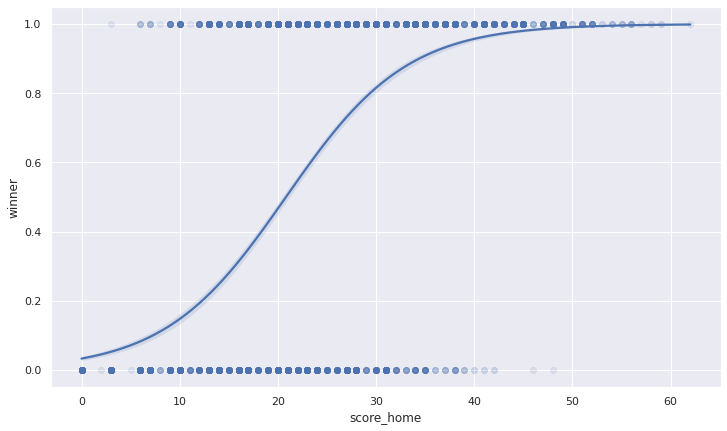

In [12]:
sns.set(rc={'figure.figsize':(12,7)})
g = sns.regplot(x=data['score_home'], y=data['winner'], logistic=True, scatter_kws={'alpha':0.1})

Logistic Regression Model to see if we can predict the winner based on all statistics other than the scores.  (Using the score would be to 'easy'.)

In [13]:
# make a linear regreesion model to predict the hom team score
model = sm.OLS(data['winner'], data.select_dtypes(['number']).drop(columns=['winner','score_diff','score_home','score_away']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 winner   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.840
Method:                 Least Squares   F-statistic:                              585.4
Date:                Tue, 11 Oct 2022   Prob (F-statistic):                        0.00
Time:                        10:47:31   Log-Likelihood:                         -1139.2
No. Observations:                5357   AIC:                                      2374.
Df Residuals:                    5309   BIC:                                      2691.
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
first_downs_away               0.0027      0.003      0.930      0.353      -0.003       0.009
first_downs_home               0.0031      0.003      1.124      0.261      -0.002       0.009
third_downs_away              -0.0308      0.012     -2.552      0.011      -0.054      -0.007
third_downs_home               0.0079      0.006      1.383      0.167      -0.003       0.019
fourth_downs_away             -0.0658      0.014     -4.777      0.000      -0.093      -0.039
fourth_downs_home              0.0079      0.006      1.383      0.167      -0.003       0.019
passing_yards_away            -0.0007   7.34e-05     -9.048      0.000      -0.001      -0.001
passing_yards_home             0.0006    7.1e-05      8.482      0.000       0.000       0.001
rushing_yards_away             0.0003    9.6e-05      2.714      0.007    7.23e-05       0.000
rushing_yards_home            -0.0002   9.15e-05     -1.803      0.071      -0.000    1.44e-05
total_yards_away              -0.0004   6.99e-05     -5.776      0.000      -0.001      -0.000
total_yards_home               0.0004   6.81e-05      6.412      0.000       0.000       0.001
sacks_away                     0.0042      0.006      0.745      0.457      -0.007       0.015
sacks_home                    -0.0137      0.006     -2.336      0.020      -0.025      -0.002
rushing_attempts_away         -0.0145      0.002     -6.546      0.000      -0.019      -0.010
rushing_attempts_home          0.0066      0.002      3.168      0.002       0.003       0.011
fumbles_away                   0.0353      0.004      9.158      0.000       0.028       0.043
fumbles_home                  -0.0254      0.004     -6.335      0.000      -0.033      -0.018
int_away                       0.0159      0.004      4.522      0.000       0.009       0.023
int_home                      -0.0205      0.004     -5.672      0.000      -0.028      -0.013
turnovers_away                 0.0513      0.003     18.539      0.000       0.046       0.057
turnovers_home                -0.0459      0.003    -16.627      0.000      -0.051      -0.040
penalties_away                 0.0059      0.003      2.029      0.042       0.000       0.012
penalties_home                -0.0019      0.003     -0.626      0.532      -0.008       0.004
drives_away                   -0.0143      0.003     -4.354      0.000      -0.021      -0.008
drives_home                    0.0167      0.003      4.948      0.000       0.010       0.023
def_st_td_away                -0.0411      0.006     -6.965      0.000      -0.053      -0.029
def_st_td_home                 0.0292      0.006      5.164      0.000       0.018       0.040
possession_away             8.949e-05  

In [14]:
# show the results sorted by coef or p-score
results_df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]
results_df.sort_values('coef')
results_df.sort_values('P>|t|')

,coef,std err,t,P>|t|,[0.025,0.975]
def_st_td_home,0.029200,0.006000,5.164,0.000,0.018000,0.040000
penalties_yards_home,-0.001400,0.000000,-4.211,0.000,-0.002000,-0.001000
pass_attempt_home,-0.024400,0.004000,-6.859,0.000,-0.031000,-0.017000
complete_passes_home,0.025000,0.005000,4.843,0.000,0.015000,0.035000
fourth_downs_attempts_away,0.068900,0.007000,10.316,0.000,0.056000,0.082000
third_downs_attempts_away,0.027300,0.007000,4.038,0.000,0.014000,0.041000
def_st_td_away,-0.041100,0.006000,-6.965,0.000,-0.053000,-0.029000
drives_home,0.016700,0.003000,4.948,0.000,0.010000,0.023000
drives_away,-0.014300,0.003000,-4.354,0.000,-0.021000,-0.008000
turnovers_home,-0.045900,0.003000,-16.627,0.000,-0.051000,-0.040000


Pairs Plot of all features

In [15]:
# Skip to reduce runtime
#g = sns.pairplot(data.select_dtypes(include=["number"]), hue="winner", palette="tab10", diag_kws={'bw':'1.0'}, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1})#

List all the features.

In [16]:
feature_names = ''
for feature_name in data.columns:
    feature_names = feature_names+' | '+feature_name
print(feature_names)

 | date | away | home | first_downs_away | first_downs_home | third_downs_away | third_downs_home | fourth_downs_away | fourth_downs_home | passing_yards_away | passing_yards_home | rushing_yards_away | rushing_yards_home | total_yards_away | total_yards_home | sacks_away | sacks_home | rushing_attempts_away | rushing_attempts_home | fumbles_away | fumbles_home | int_away | int_home | turnovers_away | turnovers_home | penalties_away | penalties_home | drives_away | drives_home | def_st_td_away | def_st_td_home | possession_away | possession_home | score_away | score_home | score_diff | winner | third_downs_rate_away | third_downs_attempts_away | third_downs_rate_home | third_downs_attempts_home | fourth_downs_rate_away | fourth_downs_attempts_away | fourth_downs_rate_home | fourth_downs_attempts_home | complete_passes_away | pass_completion_rate_away | pass_attempt_away | complete_passes_home | pass_completion_rate_home | pass_attempt_home | pressures_away | pressures_home | penalties_

# 3. Build per-team data frame

In [17]:
team_names = np.unique(data.away)
print(team_names)

['49ers' 'Bears' 'Bengals' 'Bills' 'Broncos' 'Browns' 'Buccaneers'
 'Cardinals' 'Chargers' 'Chiefs' 'Colts' 'Cowboys' 'Dolphins' 'Eagles'
 'Falcons' 'Giants' 'Jaguars' 'Jets' 'Lions' 'Packers' 'Panthers'
 'Patriots' 'Raiders' 'Rams' 'Ravens' 'Saints' 'Seahawks' 'Steelers'
 'Texans' 'Titans' 'Vikings' 'Washington']


View basic info about the data using the describe method.

In [18]:
data.head()

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,sacks_away,sacks_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,penalties_away,penalties_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,score_diff,winner,third_downs_rate_away,third_downs_attempts_away,third_downs_rate_home,third_downs_attempts_home,fourth_downs_rate_away,fourth_downs_attempts_away,fourth_downs_rate_home,fourth_downs_attempts_home,complete_passes_away,pass_completion_rate_away,pass_attempt_away,complete_passes_home,pass_completion_rate_home,pass_attempt_home,pressures_away,pressures_home,penalties_yards_away,penalties_yards_home,redzone_sucess_away,redzone_rate_away,redzone_attempts_away,redzone_sucess_home,redzone_rate_home,redzone_attempts_home,season
0,2002-09-05,49ers,Giants,13,21,4,9.0,0,9.0,166,318,113,43,279,361,0,3,25,22,0,0,1,3,1,3,5,10,13,15,0,0,1652.0,1948.0,16,13,-3,0,0.333333,12,0.562500,16.0,0.0,0,0.562500,16.0,16,0.615385,26,28,0.622222,45,0,24,29,80,0,0.0,8,0,0.0,6,2002.0
1,2002-09-08,Jets,Bills,18,26,2,7.0,0,7.0,193,242,73,142,266,384,3,4,14,32,1,1,0,2,1,3,10,10,17,18,2,0,1266.0,2348.0,37,31,-6,0,0.250000,8,0.411765,17.0,0.0,0,0.411765,17.0,24,0.800000,30,26,0.666667,39,17,29,90,82,0,0.0,9,0,0.0,8,2002.0
2,2002-09-08,Vikings,Bears,19,20,5,7.0,0,7.0,228,288,140,80,368,368,1,1,33,26,1,1,2,1,3,2,8,4,17,17,0,0,1891.0,1709.0,23,27,4,1,0.384615,13,0.538462,13.0,0.0,0,0.538462,13.0,16,0.571429,28,20,0.606061,33,6,9,52,33,0,0.0,7,0,0.0,6,2002.0
3,2002-09-08,Chargers,Bengals,27,13,6,4.0,0,4.0,160,167,241,36,401,203,1,4,45,13,0,0,0,1,0,1,4,9,11,15,0,0,2268.0,1332.0,34,6,-28,0,0.600000,10,0.363636,11.0,0.0,0,0.363636,11.0,15,0.789474,19,18,0.580645,31,0,31,39,57,0,0.0,7,0,0.0,5,2002.0
4,2002-09-08,Chiefs,Browns,24,24,5,4.0,0,4.0,276,352,194,59,470,411,0,1,30,20,0,1,1,0,1,1,9,4,20,17,0,0,1816.0,1784.0,40,39,-1,0,0.454545,11,0.363636,11.0,0.0,0,0.363636,11.0,20,0.689655,29,28,0.700000,40,0,7,87,38,0,0.0,10,0,0.0,10,2002.0


Create a dictionary team_results that will hold the results over all games for each team.

In [19]:
# create home and away dataframe
df_home = data
df_away = data

# create a column 'team' with team name and 'opponent' with the oponent temas name
df_home = df_home.rename({'home': 'team', 'away': 'opponent'}, axis=1)
df_away = df_away.rename({'away': 'team', 'home': 'opponent'}, axis=1)
# create a column 'home' determining if the game was home game
df_home['home'] = 'Y'
df_away['home'] = 'N'

# rename the columns to reflect team and opponent instead of home and away
for name in column_names[3:]:
    if 'home' in name:
        df_home = df_home.rename({name: name.replace('_home','')}, axis=1)
        df_away = df_away.rename({name: name.replace('_home','_opp')}, axis=1)
    else:
        df_home = df_home.rename({name: name.replace('_away','_opp')}, axis=1)
        df_away = df_away.rename({name: name.replace('_away','')}, axis=1)
        
df_away['winner'] = 1-df_away['winner']
df_away['score_diff'] = -df_away['score_diff']

df = pd.concat([df_home,df_away])
df['day_number'] = pd.to_numeric((pd.to_datetime(df['date']) - pd.to_datetime(data['date'][0])).dt.days, downcast='integer')
df.sort_values(by=['day_number'], inplace=True)

In [20]:
# check that there are no NaNs
df.columns[df.isna().any()].tolist()

[]

In [21]:
data.head()

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,sacks_away,sacks_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,penalties_away,penalties_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,score_diff,winner,third_downs_rate_away,third_downs_attempts_away,third_downs_rate_home,third_downs_attempts_home,fourth_downs_rate_away,fourth_downs_attempts_away,fourth_downs_rate_home,fourth_downs_attempts_home,complete_passes_away,pass_completion_rate_away,pass_attempt_away,complete_passes_home,pass_completion_rate_home,pass_attempt_home,pressures_away,pressures_home,penalties_yards_away,penalties_yards_home,redzone_sucess_away,redzone_rate_away,redzone_attempts_away,redzone_sucess_home,redzone_rate_home,redzone_attempts_home,season
0,2002-09-05,49ers,Giants,13,21,4,9.0,0,9.0,166,318,113,43,279,361,0,3,25,22,0,0,1,3,1,3,5,10,13,15,0,0,1652.0,1948.0,16,13,-3,0,0.333333,12,0.562500,16.0,0.0,0,0.562500,16.0,16,0.615385,26,28,0.622222,45,0,24,29,80,0,0.0,8,0,0.0,6,2002.0
1,2002-09-08,Jets,Bills,18,26,2,7.0,0,7.0,193,242,73,142,266,384,3,4,14,32,1,1,0,2,1,3,10,10,17,18,2,0,1266.0,2348.0,37,31,-6,0,0.250000,8,0.411765,17.0,0.0,0,0.411765,17.0,24,0.800000,30,26,0.666667,39,17,29,90,82,0,0.0,9,0,0.0,8,2002.0
2,2002-09-08,Vikings,Bears,19,20,5,7.0,0,7.0,228,288,140,80,368,368,1,1,33,26,1,1,2,1,3,2,8,4,17,17,0,0,1891.0,1709.0,23,27,4,1,0.384615,13,0.538462,13.0,0.0,0,0.538462,13.0,16,0.571429,28,20,0.606061,33,6,9,52,33,0,0.0,7,0,0.0,6,2002.0
3,2002-09-08,Chargers,Bengals,27,13,6,4.0,0,4.0,160,167,241,36,401,203,1,4,45,13,0,0,0,1,0,1,4,9,11,15,0,0,2268.0,1332.0,34,6,-28,0,0.600000,10,0.363636,11.0,0.0,0,0.363636,11.0,15,0.789474,19,18,0.580645,31,0,31,39,57,0,0.0,7,0,0.0,5,2002.0
4,2002-09-08,Chiefs,Browns,24,24,5,4.0,0,4.0,276,352,194,59,470,411,0,1,30,20,0,1,1,0,1,1,9,4,20,17,0,0,1816.0,1784.0,40,39,-1,0,0.454545,11,0.363636,11.0,0.0,0,0.363636,11.0,20,0.689655,29,28,0.700000,40,0,7,87,38,0,0.0,10,0,0.0,10,2002.0


In [22]:
df_home.head()

,date,opponent,team,first_downs_opp,first_downs,third_downs_opp,third_downs,fourth_downs_opp,fourth_downs,passing_yards_opp,passing_yards,rushing_yards_opp,rushing_yards,total_yards_opp,total_yards,sacks_opp,sacks,rushing_attempts_opp,rushing_attempts,fumbles_opp,fumbles,int_opp,int,turnovers_opp,turnovers,penalties_opp,penalties,drives_opp,drives,def_st_td_opp,def_st_td,possession_opp,possession,score_opp,score,score_diff,winner,third_downs_rate_opp,third_downs_attempts_opp,third_downs_rate,third_downs_attempts,fourth_downs_rate_opp,fourth_downs_attempts_opp,fourth_downs_rate,fourth_downs_attempts,complete_passes_opp,pass_completion_rate_opp,pass_attempt_opp,complete_passes,pass_completion_rate,pass_attempt,pressures_opp,pressures,penalties_yards_opp,penalties_yards,redzone_sucess_opp,redzone_rate_opp,redzone_attempts_opp,redzone_sucess,redzone_rate,redzone_attempts,season,home
0,2002-09-05,49ers,Giants,13,21,4,9.0,0,9.0,166,318,113,43,279,361,0,3,25,22,0,0,1,3,1,3,5,10,13,15,0,0,1652.0,1948.0,16,13,-3,0,0.333333,12,0.562500,16.0,0.0,0,0.562500,16.0,16,0.615385,26,28,0.622222,45,0,24,29,80,0,0.0,8,0,0.0,6,2002.0,Y
1,2002-09-08,Jets,Bills,18,26,2,7.0,0,7.0,193,242,73,142,266,384,3,4,14,32,1,1,0,2,1,3,10,10,17,18,2,0,1266.0,2348.0,37,31,-6,0,0.250000,8,0.411765,17.0,0.0,0,0.411765,17.0,24,0.800000,30,26,0.666667,39,17,29,90,82,0,0.0,9,0,0.0,8,2002.0,Y
2,2002-09-08,Vikings,Bears,19,20,5,7.0,0,7.0,228,288,140,80,368,368,1,1,33,26,1,1,2,1,3,2,8,4,17,17,0,0,1891.0,1709.0,23,27,4,1,0.384615,13,0.538462,13.0,0.0,0,0.538462,13.0,16,0.571429,28,20,0.606061,33,6,9,52,33,0,0.0,7,0,0.0,6,2002.0,Y
3,2002-09-08,Chargers,Bengals,27,13,6,4.0,0,4.0,160,167,241,36,401,203,1,4,45,13,0,0,0,1,0,1,4,9,11,15,0,0,2268.0,1332.0,34,6,-28,0,0.600000,10,0.363636,11.0,0.0,0,0.363636,11.0,15,0.789474,19,18,0.580645,31,0,31,39,57,0,0.0,7,0,0.0,5,2002.0,Y
4,2002-09-08,Chiefs,Browns,24,24,5,4.0,0,4.0,276,352,194,59,470,411,0,1,30,20,0,1,1,0,1,1,9,4,20,17,0,0,1816.0,1784.0,40,39,-1,0,0.454545,11,0.363636,11.0,0.0,0,0.363636,11.0,20,0.689655,29,28,0.700000,40,0,7,87,38,0,0.0,10,0,0.0,10,2002.0,Y


In [23]:
df_away.head()

,date,team,opponent,first_downs,first_downs_opp,third_downs,third_downs_opp,fourth_downs,fourth_downs_opp,passing_yards,passing_yards_opp,rushing_yards,rushing_yards_opp,total_yards,total_yards_opp,sacks,sacks_opp,rushing_attempts,rushing_attempts_opp,fumbles,fumbles_opp,int,int_opp,turnovers,turnovers_opp,penalties,penalties_opp,drives,drives_opp,def_st_td,def_st_td_opp,possession,possession_opp,score,score_opp,score_diff,winner,third_downs_rate,third_downs_attempts,third_downs_rate_opp,third_downs_attempts_opp,fourth_downs_rate,fourth_downs_attempts,fourth_downs_rate_opp,fourth_downs_attempts_opp,complete_passes,pass_completion_rate,pass_attempt,complete_passes_opp,pass_completion_rate_opp,pass_attempt_opp,pressures,pressures_opp,penalties_yards,penalties_yards_opp,redzone_sucess,redzone_rate,redzone_attempts,redzone_sucess_opp,redzone_rate_opp,redzone_attempts_opp,season,home
0,2002-09-05,49ers,Giants,13,21,4,9.0,0,9.0,166,318,113,43,279,361,0,3,25,22,0,0,1,3,1,3,5,10,13,15,0,0,1652.0,1948.0,16,13,3,1,0.333333,12,0.562500,16.0,0.0,0,0.562500,16.0,16,0.615385,26,28,0.622222,45,0,24,29,80,0,0.0,8,0,0.0,6,2002.0,N
1,2002-09-08,Jets,Bills,18,26,2,7.0,0,7.0,193,242,73,142,266,384,3,4,14,32,1,1,0,2,1,3,10,10,17,18,2,0,1266.0,2348.0,37,31,6,1,0.250000,8,0.411765,17.0,0.0,0,0.411765,17.0,24,0.800000,30,26,0.666667,39,17,29,90,82,0,0.0,9,0,0.0,8,2002.0,N
2,2002-09-08,Vikings,Bears,19,20,5,7.0,0,7.0,228,288,140,80,368,368,1,1,33,26,1,1,2,1,3,2,8,4,17,17,0,0,1891.0,1709.0,23,27,-4,0,0.384615,13,0.538462,13.0,0.0,0,0.538462,13.0,16,0.571429,28,20,0.606061,33,6,9,52,33,0,0.0,7,0,0.0,6,2002.0,N
3,2002-09-08,Chargers,Bengals,27,13,6,4.0,0,4.0,160,167,241,36,401,203,1,4,45,13,0,0,0,1,0,1,4,9,11,15,0,0,2268.0,1332.0,34,6,28,1,0.600000,10,0.363636,11.0,0.0,0,0.363636,11.0,15,0.789474,19,18,0.580645,31,0,31,39,57,0,0.0,7,0,0.0,5,2002.0,N
4,2002-09-08,Chiefs,Browns,24,24,5,4.0,0,4.0,276,352,194,59,470,411,0,1,30,20,0,1,1,0,1,1,9,4,20,17,0,0,1816.0,1784.0,40,39,1,1,0.454545,11,0.363636,11.0,0.0,0,0.363636,11.0,20,0.689655,29,28,0.700000,40,0,7,87,38,0,0.0,10,0,0.0,10,2002.0,N


In [24]:
df.head()

,date,opponent,team,first_downs_opp,first_downs,third_downs_opp,third_downs,fourth_downs_opp,fourth_downs,passing_yards_opp,passing_yards,rushing_yards_opp,rushing_yards,total_yards_opp,total_yards,sacks_opp,sacks,rushing_attempts_opp,rushing_attempts,fumbles_opp,fumbles,int_opp,int,turnovers_opp,turnovers,penalties_opp,penalties,drives_opp,drives,def_st_td_opp,def_st_td,possession_opp,possession,score_opp,score,score_diff,winner,third_downs_rate_opp,third_downs_attempts_opp,third_downs_rate,third_downs_attempts,fourth_downs_rate_opp,fourth_downs_attempts_opp,fourth_downs_rate,fourth_downs_attempts,complete_passes_opp,pass_completion_rate_opp,pass_attempt_opp,complete_passes,pass_completion_rate,pass_attempt,pressures_opp,pressures,penalties_yards_opp,penalties_yards,redzone_sucess_opp,redzone_rate_opp,redzone_attempts_opp,redzone_sucess,redzone_rate,redzone_attempts,season,home,day_number
0,2002-09-05,49ers,Giants,13,21,4.0,9.0,0.0,9.0,166,318,113,43,279,361,0,3,25,22,0,0,1,3,1,3,5,10,13,15,0,0,1652.0,1948.0,16,13,-3,0,0.333333,12.0,0.562500,16.0,0.000000,0.0,0.5625,16.0,16,0.615385,26,28,0.622222,45,0,24,29,80,0,0.0,8,0,0.0,6,2002.0,Y,0
0,2002-09-05,Giants,49ers,21,13,9.0,4.0,9.0,0.0,318,166,43,113,361,279,3,0,22,25,0,0,3,1,3,1,10,5,15,13,0,0,1948.0,1652.0,13,16,3,1,0.562500,16.0,0.333333,12.0,0.562500,16.0,0.0000,0.0,28,0.622222,45,16,0.615385,26,24,0,80,29,0,0.0,6,0,0.0,8,2002.0,N,0
13,2002-09-08,Buccaneers,Saints,19,21,7.0,10.0,7.0,0.0,261,250,72,118,333,368,3,2,21,34,0,0,1,1,1,1,8,5,4,4,0,2,1889.0,2441.0,20,26,6,1,0.368421,19.0,0.500000,20.0,0.368421,19.0,0.0000,0.0,28,0.528302,53,24,0.571429,42,17,10,85,45,0,0.0,2,0,0.0,1,2002.0,N,3
14,2002-09-08,Texans,Cowboys,13,11,2.0,2.0,2.0,0.0,123,112,87,155,210,267,6,3,35,24,0,1,1,1,1,2,11,9,19,18,0,0,2035.0,1565.0,19,10,-9,0,0.133333,15.0,0.153846,13.0,0.133333,15.0,0.0000,0.0,10,0.454545,22,13,0.433333,30,22,19,80,117,0,0.0,4,0,0.0,2,2002.0,N,3
10,2002-09-08,Jaguars,Colts,19,18,8.0,9.0,8.0,0.0,225,203,118,104,343,307,1,1,32,28,1,2,1,0,2,2,5,2,16,17,0,2,1953.0,1647.0,25,28,3,1,0.500000,16.0,0.642857,14.0,0.500000,16.0,0.0000,0.0,22,0.611111,36,19,0.612903,31,3,8,40,14,0,0.0,8,0,0.0,6,2002.0,N,3


## This is a good staring spot with home and away joined. Lets subset to the past 7 years

In [25]:
top = int(len(df)/1.67)
df_new = df.iloc[top:-1]
df_new.columns

Index(['date', 'opponent', 'team', 'first_downs_opp', 'first_downs',
       'third_downs_opp', 'third_downs', 'fourth_downs_opp', 'fourth_downs',
       'passing_yards_opp', 'passing_yards', 'rushing_yards_opp',
       'rushing_yards', 'total_yards_opp', 'total_yards', 'sacks_opp', 'sacks',
       'rushing_attempts_opp', 'rushing_attempts', 'fumbles_opp', 'fumbles',
       'int_opp', 'int', 'turnovers_opp', 'turnovers', 'penalties_opp',
       'penalties', 'drives_opp', 'drives', 'def_st_td_opp', 'def_st_td',
       'possession_opp', 'possession', 'score_opp', 'score', 'score_diff',
       'winner', 'third_downs_rate_opp', 'third_downs_attempts_opp',
       'third_downs_rate', 'third_downs_attempts', 'fourth_downs_rate_opp',
       'fourth_downs_attempts_opp', 'fourth_downs_rate',
       'fourth_downs_attempts', 'complete_passes_opp',
       'pass_completion_rate_opp', 'pass_attempt_opp', 'complete_passes',
       'pass_completion_rate', 'pass_attempt', 'pressures_opp', 'pressures',
  

In [26]:
team_results = {}
team_results_avg = {}     
for name in team_names:
    team_results[name] = df_new.loc[df_new['team'] == name].sort_values(by=['day_number'], inplace=False)
    team_results_avg[name] = df_new.loc[df_new['team'] == name].sort_values(by=['day_number'], inplace=False)

In [27]:
N = 20

column_indices_to_avg = np.where([x in team_results['Bills'].select_dtypes(['number']).columns for x in team_results['Bills'].columns])

for name in team_names:
    for idx in range(N,team_results[name].shape[0]):
        # Determine the days to the previous games, then weights for then weighted average.
        # Weights drop by about 7% for each previous week, or
        # by 90% going back to a previous season
        days = team_results[name].iloc[(idx-N):(idx-1)]['day_number'].to_numpy(dtype=float)
        days = days-days[-1]
        coeff = np.exp(days/200)/np.sum(np.exp(days/400))
        for col_idx in column_indices_to_avg:
            team_results_avg[name].iloc[idx,col_idx] = np.dot(coeff,team_results[name].iloc[(idx-N):(idx-1),col_idx])
    

# End of my adds

Create the per-team data frames

In [28]:
team_results = {}
team_results_avg = {}     
for name in team_names:
    team_results[name] = df.loc[df['team'] == name].sort_values(by=['day_number'], inplace=False)
    team_results_avg[name] = df.loc[df['team'] == name].sort_values(by=['day_number'], inplace=False)

In [29]:
# check the result
team_results['Bills']

,date,opponent,team,first_downs_opp,first_downs,third_downs_opp,third_downs,fourth_downs_opp,fourth_downs,passing_yards_opp,passing_yards,rushing_yards_opp,rushing_yards,total_yards_opp,total_yards,sacks_opp,sacks,rushing_attempts_opp,rushing_attempts,fumbles_opp,fumbles,int_opp,int,turnovers_opp,turnovers,penalties_opp,penalties,drives_opp,drives,def_st_td_opp,def_st_td,possession_opp,possession,score_opp,score,score_diff,winner,third_downs_rate_opp,third_downs_attempts_opp,third_downs_rate,third_downs_attempts,fourth_downs_rate_opp,fourth_downs_attempts_opp,fourth_downs_rate,fourth_downs_attempts,complete_passes_opp,pass_completion_rate_opp,pass_attempt_opp,complete_passes,pass_completion_rate,pass_attempt,pressures_opp,pressures,penalties_yards_opp,penalties_yards,redzone_sucess_opp,redzone_rate_opp,redzone_attempts_opp,redzone_sucess,redzone_rate,redzone_attempts,season,home,day_number
1,2002-09-08,Jets,Bills,18,26,2.0,7.0,0.0,7.0,193,242,73,142,266,384,3,4,14,32,1,1,0,2,1,3,10,10,17,18,2,0,1266.0,2348.0,37,31,-6,0,0.250000,8.0,0.411765,17.0,0.000000,0.0,0.411765,17.0,24,0.800000,30,26,0.666667,39,17,29,90,82,0,0.00,9,0,0.000000,8,2002.0,Y,3
27,2002-09-15,Vikings,Bills,31,26,7.0,4.0,7.0,0.0,236,437,213,31,449,468,5,3,39,14,3,0,0,0,3,0,8,6,21,22,0,3,2389.0,1823.0,39,45,6,1,0.437500,16.0,0.333333,12.0,0.437500,16.0,0.000000,0.0,25,0.543478,46,35,0.714286,49,45,26,65,65,0,0.00,13,0,0.000000,10,2002.0,N,10
39,2002-09-22,Broncos,Bills,22,17,3.0,6.0,3.0,0.0,179,252,163,39,342,291,4,4,32,14,0,1,0,0,0,1,9,10,16,16,2,0,1967.0,1633.0,28,23,-5,0,0.230769,13.0,0.428571,14.0,0.230769,13.0,0.000000,0.0,19,0.612903,31,27,0.658537,41,32,31,64,82,0,0.00,2,0,0.000000,7,2002.0,N,17
46,2002-09-29,Bears,Bills,15,26,6.0,5.0,0.0,5.0,188,307,52,103,240,410,0,2,26,25,0,1,0,0,0,1,5,9,17,18,2,0,1744.0,1974.0,27,33,6,1,0.428571,14.0,0.454545,11.0,0.000000,0.0,0.454545,11.0,19,0.612903,31,28,0.777778,36,0,21,55,82,0,0.00,8,0,0.000000,8,2002.0,Y,24
61,2002-10-06,Raiders,Bills,24,29,6.0,7.0,0.0,7.0,353,399,142,80,495,479,1,5,27,18,0,0,0,3,0,3,10,7,19,20,2,0,1708.0,1892.0,49,31,-18,0,0.461538,13.0,0.466667,15.0,0.000000,0.0,0.466667,15.0,23,0.605263,38,32,0.603774,53,4,18,120,43,0,0.00,8,0,0.000000,7,2002.0,Y,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5302,2021-12-26,Patriots,Bills,20,28,1.0,6.0,1.0,3.0,139,314,149,114,288,428,1,0,27,28,0,0,2,0,2,0,3,5,8,9,0,0,1491.0,2109.0,21,33,12,1,0.100000,10.0,0.500000,12.0,0.100000,10.0,0.750000,4.0,14,0.437500,32,30,0.638298,47,6,0,30,45,3,1.00,3,4,0.571429,7,2021.0,N,7052
5312,2022-01-02,Falcons,Bills,18,28,1.0,7.0,0.0,7.0,169,118,96,233,265,351,5,1,22,44,1,0,0,3,1,3,4,7,9,8,0,0,1433.0,2167.0,15,29,14,1,0.142857,7.0,0.583333,12.0,0.000000,1.0,0.583333,12.0,13,0.565217,23,11,0.423077,26,28,2,27,47,1,0.25,4,4,0.800000,5,2021.0,Y,7059
5338,2022-01-09,Jets,Bills,4,25,1.0,8.0,1.0,8.0,5,254,48,170,53,424,9,0,17,33,0,0,0,0,0,0,4,4,13,14,0,0,1380.0,2220.0,10,27,17,1,0.071429,14.0,0.444444,18.0,1.000000,1.0,0.444444,18.0,7,0.350000,20,25,0.543478,46,82,0,27,40,0,0.00,0,3,0.750000,4,2021.0,Y,7066
5345,2022-01-15,Patriots,Bills,20,29,7.0,6.0,4.0,6.0,216,308,89,174,305,482,3,0,20,29,0,0,2,0,2,0,5,3,8,9,0,0,1715.0,1885.0,17,47,30,1,0.500000,14.0,0.857143,7.0,1.000000,4.0,0.857143,7.0,24,0.631579,38,21,0.840000,25,16,0,34,47,2,1.00,2,6,1.000000,6,2021.0,Y,7072


Create a weighted average of previous games.

In [30]:
N = 20

column_indices_to_avg = np.where([x in team_results['Bills'].select_dtypes(['number']).columns for x in team_results['Bills'].columns])

for name in team_names:
    for idx in range(N,team_results[name].shape[0]):
        # Determine the days to the previous games, then weights for then weighted average.
        # Weights drop by about 7% for each previous week, or
        # by 90% going back to a previous season
        days = team_results[name].iloc[(idx-N):(idx-1)]['day_number'].to_numpy(dtype=float)
        days = days-days[-1]
        coeff = np.exp(days/200)/np.sum(np.exp(days/400))
        for col_idx in column_indices_to_avg:
            team_results_avg[name].iloc[idx,col_idx] = np.dot(coeff,team_results[name].iloc[(idx-N):(idx-1),col_idx])
    

In [31]:
team_results_avg['Bills'][['date','team','home','opponent','winner','score','score_opp','score_diff']]

,date,team,home,opponent,winner,score,score_opp,score_diff
1,2002-09-08,Bills,Y,Jets,0.000000,31.000000,37.000000,-6.000000
27,2002-09-15,Bills,N,Vikings,1.000000,45.000000,39.000000,6.000000
39,2002-09-22,Bills,N,Broncos,0.000000,23.000000,28.000000,-5.000000
46,2002-09-29,Bills,Y,Bears,1.000000,33.000000,27.000000,6.000000
61,2002-10-06,Bills,Y,Raiders,0.000000,31.000000,49.000000,-18.000000
...,...,...,...,...,...,...,...,...
5302,2021-12-26,Bills,N,Patriots,0.441350,22.779418,14.896594,7.882823
5312,2022-01-02,Bills,Y,Falcons,0.473483,23.061913,14.787664,8.274250
5338,2022-01-09,Bills,Y,Jets,0.502826,23.554055,15.260406,8.293649
5345,2022-01-15,Bills,Y,Patriots,0.529717,23.545552,15.115603,8.429948


Plot the recent-time-averages score diff as a function of date for the Bills and Patriots.

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


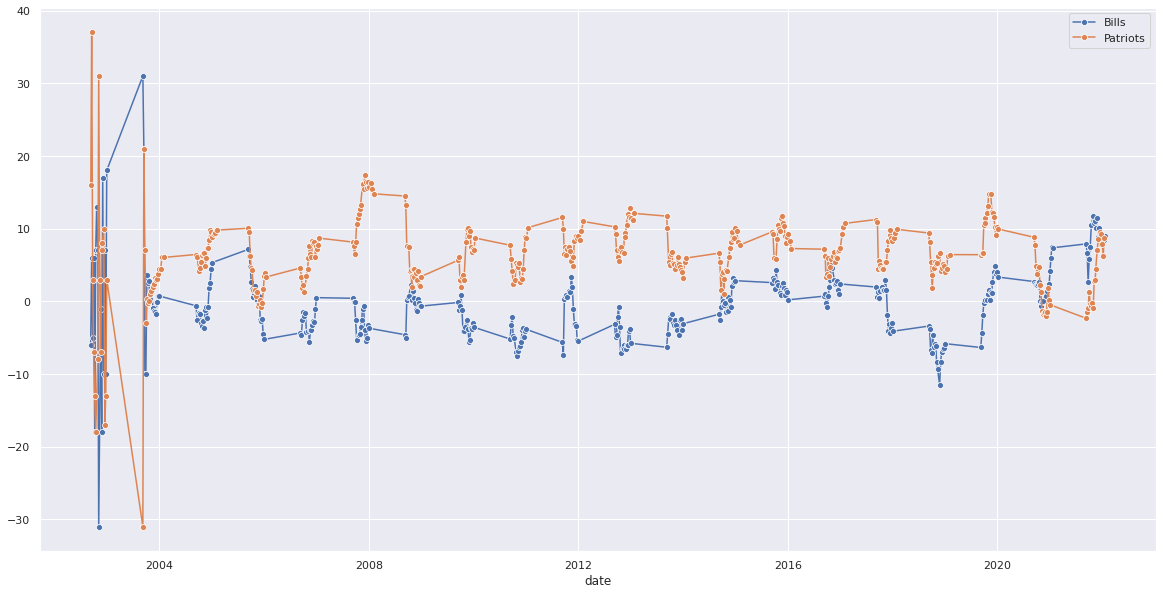

In [32]:
import matplotlib.dates as mdates

sns.set(rc={'figure.figsize':(20,10)})
fig, ax = plt.subplots()
plot_ = sns.lineplot(pd.to_datetime(team_results_avg['Bills'].date),team_results_avg['Bills'].score_diff.to_numpy(), label='Bills', marker='o')
plot_ = sns.lineplot(pd.to_datetime(team_results_avg['Patriots'].date),team_results_avg['Patriots'].score_diff.to_numpy(), label='Patriots', marker='o')

#ax.set_ylim([-15,20]);

In [33]:
team_results['Bills'].columns[team_results['Bills'].isna().any()].tolist()

[]

In [34]:
team_results_avg['Bills'].columns[team_results_avg['Bills'].isna().any()].tolist()

[]

In [35]:
# Create initial data_home and data_away data frames as empty data frames with the correct column names
data_home = pd.DataFrame(columns = team_results_avg['Bills'].columns) 
data_away = pd.DataFrame(columns = team_results_avg['Bills'].columns) 

for idx in range(data.shape[0]):
    # get the date for this row
    date = data.iloc[idx].date
    # get the home and away team for this row
    home_team = data.iloc[idx].home
    away_team = data.iloc[idx].away
    home_data = team_results_avg[home_team].loc[team_results_avg[home_team]['date'] == date]
    away_data = team_results_avg[away_team].loc[team_results_avg[away_team]['date'] == date]
    # concatonate the rows to each data_home, data_away
    data_home = pd.concat([data_home,home_data])
    data_away = pd.concat([data_away,away_data])
    
# append '_homeAvg' and '_awayAvg' to the home and away datframes
for name in data_home.columns:
    data_home = data_home.rename({name: name+'_homeAvg'}, axis=1)
    data_away = data_away.rename({name: name+'_awayAvg'}, axis=1)

# drop un-needed columns the home and away datframes
data_home = data_home.drop(['date_homeAvg', 'team_homeAvg', 'opponent_homeAvg'], axis=1)
data_away = data_away.drop(['date_awayAvg', 'team_awayAvg', 'opponent_awayAvg'], axis=1)

In [36]:
df = pd.concat([data[['date','home','away','winner','score_home','score_away','score_diff']],data_home,data_away], axis=1, sort=False)

In [37]:
df.columns[df.isna().any()].tolist()

[]

In [38]:
df.tail()

,date,home,away,winner,score_home,score_away,score_diff,first_downs_opp_homeAvg,first_downs_homeAvg,third_downs_opp_homeAvg,third_downs_homeAvg,fourth_downs_opp_homeAvg,fourth_downs_homeAvg,passing_yards_opp_homeAvg,passing_yards_homeAvg,rushing_yards_opp_homeAvg,rushing_yards_homeAvg,total_yards_opp_homeAvg,total_yards_homeAvg,sacks_opp_homeAvg,sacks_homeAvg,rushing_attempts_opp_homeAvg,rushing_attempts_homeAvg,fumbles_opp_homeAvg,fumbles_homeAvg,int_opp_homeAvg,int_homeAvg,turnovers_opp_homeAvg,turnovers_homeAvg,penalties_opp_homeAvg,penalties_homeAvg,drives_opp_homeAvg,drives_homeAvg,def_st_td_opp_homeAvg,def_st_td_homeAvg,possession_opp_homeAvg,possession_homeAvg,score_opp_homeAvg,score_homeAvg,score_diff_homeAvg,winner_homeAvg,third_downs_rate_opp_homeAvg,third_downs_attempts_opp_homeAvg,third_downs_rate_homeAvg,third_downs_attempts_homeAvg,fourth_downs_rate_opp_homeAvg,fourth_downs_attempts_opp_homeAvg,fourth_downs_rate_homeAvg,fourth_downs_attempts_homeAvg,complete_passes_opp_homeAvg,...,total_yards_awayAvg,sacks_opp_awayAvg,sacks_awayAvg,rushing_attempts_opp_awayAvg,rushing_attempts_awayAvg,fumbles_opp_awayAvg,fumbles_awayAvg,int_opp_awayAvg,int_awayAvg,turnovers_opp_awayAvg,turnovers_awayAvg,penalties_opp_awayAvg,penalties_awayAvg,drives_opp_awayAvg,drives_awayAvg,def_st_td_opp_awayAvg,def_st_td_awayAvg,possession_opp_awayAvg,possession_awayAvg,score_opp_awayAvg,score_awayAvg,score_diff_awayAvg,winner_awayAvg,third_downs_rate_opp_awayAvg,third_downs_attempts_opp_awayAvg,third_downs_rate_awayAvg,third_downs_attempts_awayAvg,fourth_downs_rate_opp_awayAvg,fourth_downs_attempts_opp_awayAvg,fourth_downs_rate_awayAvg,fourth_downs_attempts_awayAvg,complete_passes_opp_awayAvg,pass_completion_rate_opp_awayAvg,pass_attempt_opp_awayAvg,complete_passes_awayAvg,pass_completion_rate_awayAvg,pass_attempt_awayAvg,pressures_opp_awayAvg,pressures_awayAvg,penalties_yards_opp_awayAvg,penalties_yards_awayAvg,redzone_sucess_opp_awayAvg,redzone_rate_opp_awayAvg,redzone_attempts_opp_awayAvg,redzone_sucess_awayAvg,redzone_rate_awayAvg,redzone_attempts_awayAvg,season_awayAvg,home_awayAvg,day_number_awayAvg
5352,2022-01-23,Buccaneers,Rams,0,27,30,-3,17.052305,20.002375,4.303757,5.269154,3.310910,2.487174,199.192988,257.470163,81.468390,84.931227,280.661378,342.401391,2.447862,1.128295,18.475902,19.497351,0.614418,0.305504,0.818414,0.609139,1.432831,0.914643,3.934920,4.502269,9.518131,9.739113,0.099231,0.073415,1523.216024,1546.952232,17.076195,25.276461,8.200265,0.658923,0.305583,11.377805,0.395709,11.200128,0.295316,7.236167,0.363975,5.685977,21.889597,...,309.454851,2.504768,1.679667,22.317579,21.056683,0.311188,0.243189,0.930451,0.938415,1.241639,1.181604,4.411842,3.731836,9.081979,9.063878,0.247455,0.070533,1600.801727,1482.236772,18.585485,22.582779,3.997294,0.584544,0.344463,11.203980,0.358279,10.315717,0.295582,6.993446,0.404248,5.636305,20.296212,0.561107,30.724104,20.040121,0.569400,30.031112,18.204318,13.328737,34.576659,30.867869,1.428049,0.477551,2.765151,2.049533,0.495423,3.426942,1713.093248,N,5938.081576
5353,2022-01-23,Chiefs,Bills,1,42,36,6,18.005949,20.765085,4.006287,5.307981,2.895071,2.922346,210.479815,237.010144,99.719885,98.068659,310.199700,335.078803,1.614168,1.374983,20.792675,21.575077,0.745599,0.539377,0.732131,0.595706,1.477730,1.135084,5.607868,5.565393,8.511491,8.459523,0.040990,0.211591,1477.855347,1578.967085,17.746094,24.080654,6.334561,0.613423,0.334568,10.038441,0.429056,10.294468,0.442719,5.725362,0.437611,5.892567,20.127025,...,321.448328,2.208287,1.381848,22.452624,22.954897,0.500106,0.271904,0.872750,0.824753,1.372856,1.096657,4.888092,5.495916,9.275266,9.345419,0.035415,0.051457,1461.190267,1615.476657,14.676251,23.702123,9.025873,0.554382,0.247747,10.715486,0.392003,11.108117,0.314306,5.929372,0.391595,6.929102,14.618679,0.471250,26.188284,20.592343,0.529139,32.828081,15.021043,8.740462,40.152806,47.359284,1.181489,0.398347,2.261554,2.414286,0.518320,3.846913,1718.755163,N,5958.709196
5354,2022-01-30,Ch

In [39]:
df[['date','home','away','winner','score_home','score_away','score_diff','score_homeAvg','score_opp_homeAvg','score_awayAvg','score_opp_awayAvg']].iloc[250:260]

,date,home,away,winner,score_home,score_away,score_diff,score_homeAvg,score_opp_homeAvg,score_awayAvg,score_opp_awayAvg
250,2002-12-29,Colts,Jaguars,1,20,13,7,20.0,13.0,13.0,20.0
251,2002-12-29,Broncos,Cardinals,1,37,7,30,37.0,7.0,7.0,37.0
252,2002-12-29,Jets,Packers,1,42,17,25,42.0,17.0,17.0,42.0
253,2002-12-29,Chargers,Seahawks,0,28,31,-3,28.0,31.0,31.0,28.0
254,2002-12-29,Bears,Buccaneers,0,0,15,-15,0.0,15.0,15.0,0.0
255,2002-12-30,Rams,49ers,1,31,20,11,31.0,20.0,20.0,31.0
256,2003-01-04,Jets,Colts,1,41,0,41,41.0,0.0,0.0,41.0
257,2003-01-04,Packers,Falcons,0,7,27,-20,7.0,27.0,27.0,7.0
258,2003-01-05,Steelers,Browns,1,36,33,3,36.0,33.0,33.0,36.0
259,2003-01-05,49ers,Giants,1,39,38,1,39.0,38.0,38.0,39.0


# 4. Now some predictive analytics

In [40]:
nDrop = 500

In [38]:
df1 = df[['date','home','away','winner','score_home','score_away','score_diff','score_homeAvg','score_opp_homeAvg','score_awayAvg','score_opp_awayAvg']]

In [39]:
X = sm.add_constant(df1[['score_homeAvg','score_opp_homeAvg','score_awayAvg','score_opp_awayAvg']].iloc[nDrop:])
Y = df1['score_home'].iloc[nDrop:]
# make a linear regreesion model to predict the hom team score
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_home   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     104.1
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           3.67e-85
Time:                        15:18:08   Log-Likelihood:                -18029.
No. Observations:                4857   AIC:                         3.607e+04
Df Residuals:                    4852   BIC:                         3.610e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.4005      0.897     22.750      0.000      18.642      22.158
score_homeAvg         0.6464      0.039     16.580      0.000       0.570       0.723
score_opp_homeAvg    -0.4110      0.048     -8.545      0.000      -0.505      -0.317
score_awayAvg        -0.3223      0.040     -8.042      0.000      -0.401      -0.244
score_opp_awayAvg     0.2714      0.048      5.695      0.000       0.178       0.365
==============================================================================
Omnibus:                       52.321   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.776
Skew:                           0.257   Prob(JB):                     2.10e-12
Kurtosis:                       3.043   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
pred_score_home = results.predict(X)

In [41]:
np.sqrt(np.mean((pred_score_home-Y)**2))

9.904687677702986

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


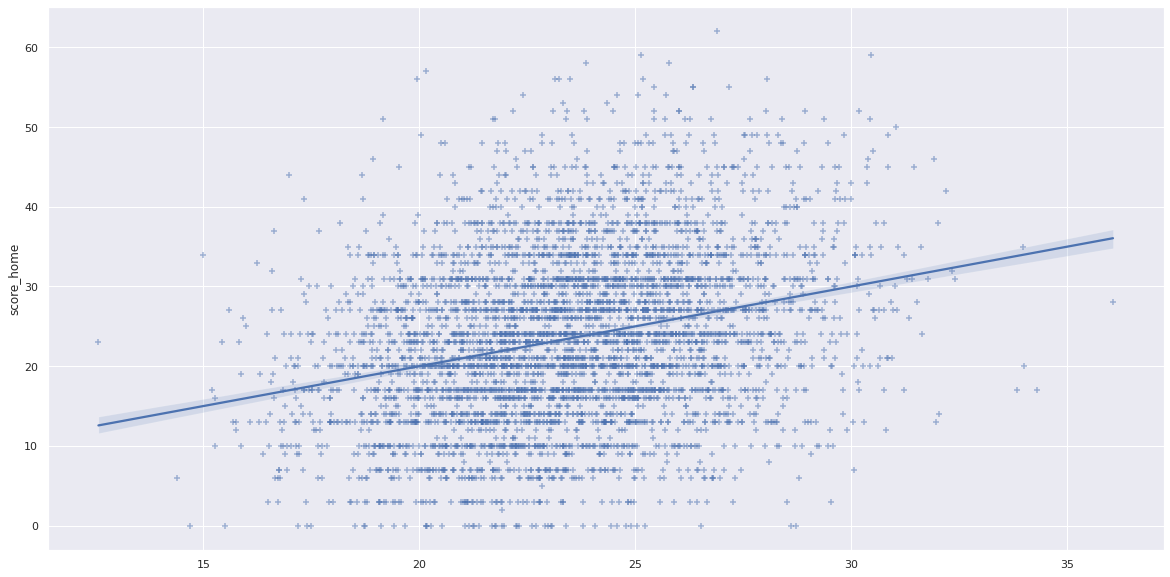

In [42]:
sns.regplot(pred_score_home,Y, marker="+",scatter_kws={'alpha':0.5});

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


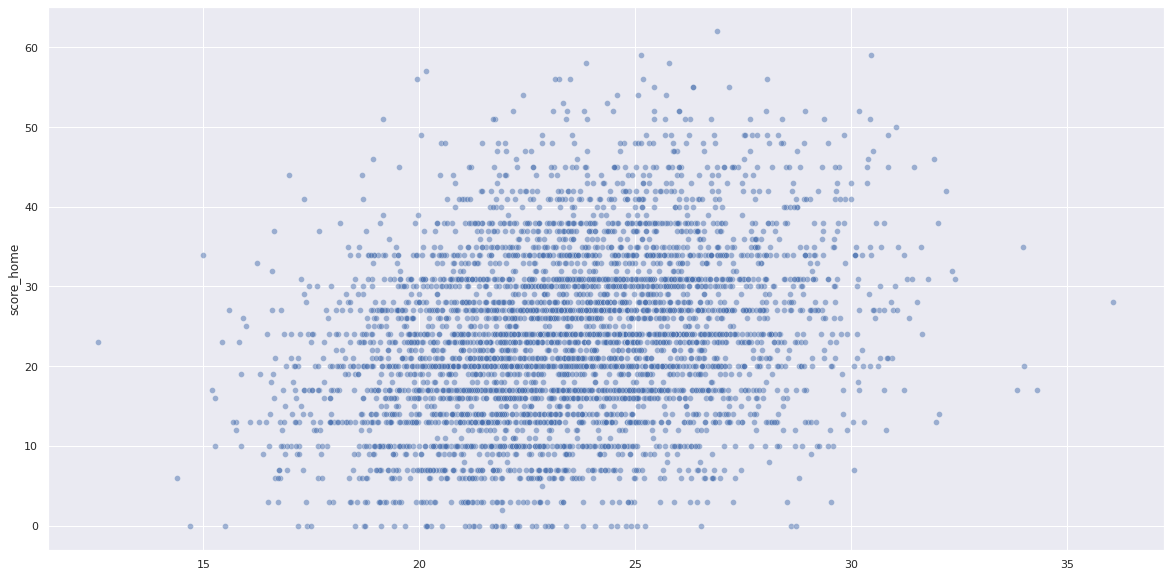

In [43]:
sns.scatterplot(pred_score_home,Y, alpha=0.5);

In [44]:
dfX = df.drop(['date','home','away','winner','score_home','score_away','score_diff','home_awayAvg','home_homeAvg'], axis=1)
dfX.columns[dfX.isna().any()].tolist()

[]

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMS:
9.640416550357559


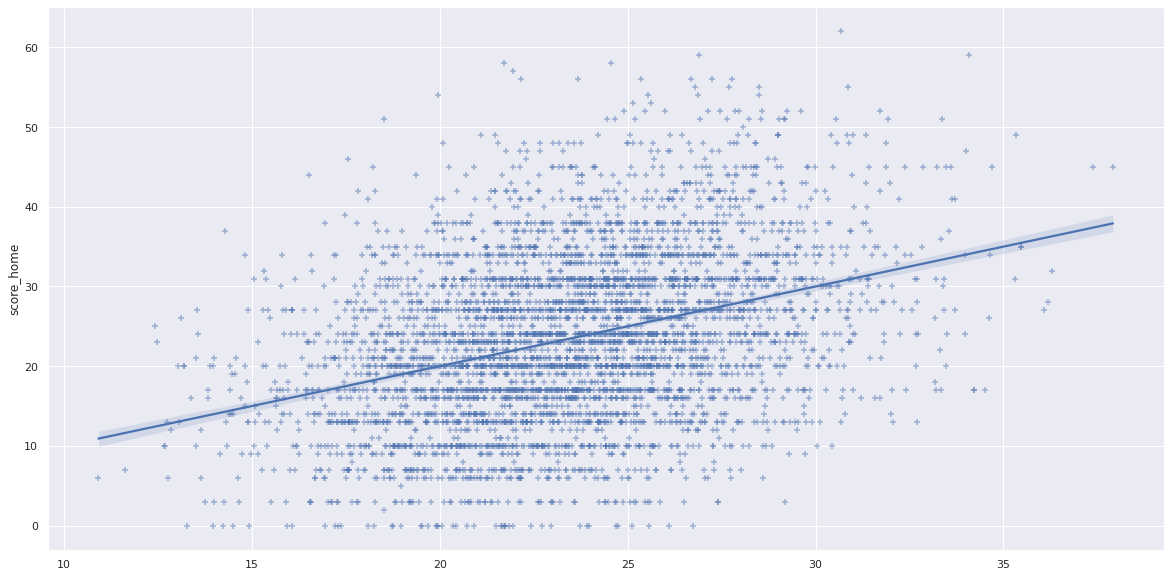

In [45]:
X = sm.add_constant(dfX.iloc[nDrop:])
Y = df['score_home'].iloc[nDrop:].astype(float)
# make a linear regreesion model to predict the hom team score
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

pred_score_home = results.predict(X)
print('RMS:')
print(np.sqrt(np.mean((pred_score_home-Y)**2)))
sns.regplot(pred_score_home,Y, marker="+",scatter_kws={'alpha':0.5});

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_home   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     6.305
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           2.38e-78
Time:                        15:19:06   Log-Likelihood:                -17898.
No. Observations:                4857   AIC:                         3.602e+04
Df Residuals:                    4746   BIC:                         3.674e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                25.4151      1.086     23.399      0.000      23.286      27.544
first_downs_opp_homeAvg              -0.7788      0.490     -1.588      0.112      -1.740       0.183
first_downs_homeAvg                  -0.4218      0.461     -0.915      0.360      -1.325       0.481
third_downs_opp_homeAvg               1.7363      2.087      0.832      0.405      -2.354       5.827
third_downs_homeAvg                  -2.5117      2.032     -1.236      0.216      -6.495       1.471
fourth_downs_opp_homeAvg             -2.8641      0.952     -3.009      0.003      -4.730      -0.998
fourth_downs_homeAvg                 -0.4323      1.007     -0.429      0.668      -2.406       1.541
passing_yards_opp_homeAvg             0.0073      0.012      0.588      0.557      -0.017       0.031
passing_yards_homeAvg                -0.0002      0.011     -0.014      0.989      -0.022       0.022
rushing_yards_opp_homeAvg             0.0045      0.016      0.293      0.770      -0.026       0.035
rushing_yards_homeAvg                 0.0036      0.014      0.261      0.794      -0.024       0.031
total_yards_opp_homeAvg               0.0118      0.012      1.022      0.307      -0.011       0.034
total_yards_homeAvg                   0.0035      0.011      0.304      0.761      -0.019       0.026
sacks_opp_homeAvg                     0.5094      0.985      0.517      0.605      -1.421       2.440
sacks_homeAvg                         0.3719      0.805      0.462      0.644      -1.207       1.951
rushing_attempts_opp_homeAvg          0.5160      0.359      1.436      0.151      -0.189       1.221
rushing_attempts_homeAvg              0.4544      0.300      1.514      0.130      -0.134       1.043
fumbles_opp_homeAvg                  -0.7027      0.704     -0.998      0.318      -2.083       0.678
fumbles_homeAvg                      -0.2211      0.690     -0.320      0.749      -1.575       1.132
int_opp_homeAvg                      -0.4726      0.610     -0.774      0.439      -1.669       0.724
int_homeAvg                           0.2533      0.625      0.405      0.685      -0.972       1.478
turnovers_opp_homeAvg                -1.1753      0.519     -2.266      0.023      -2.192      -0.159
turnovers_homeAvg                     0.0322      0.529      0.061      0.951      -1.005       1.069
penalties_opp_homeAvg                -0.3051      0.470     -0.649      0.516      -1.227       0.616
penalties_homeAvg                    -0.7447      0.455     -1.638      0.102      -1.636       0.147
drives_opp_homeAvg                   -0.0891      0.598     -0.149      0.882      -1.262       1.083
drives_homeAvg                        0.3706      0.603      0.614      0.539      -0.812       1.553
def_st_td_opp_homeAvg  

RMS:
9.736904542122176


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


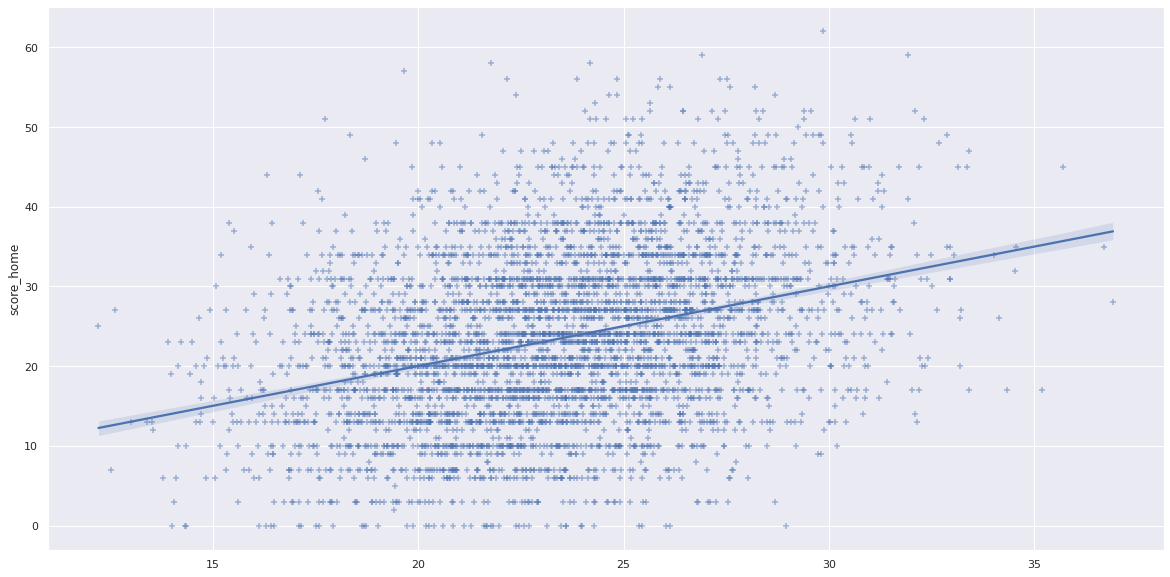

In [47]:
# make a linear regreesion model to predict the hom team score
model = sm.OLS(Y, X)
results = model.fit_regularized(method='elastic_net')

pred_score_home = results.predict(X)
print('RMS:')
print(np.sqrt(np.mean((pred_score_home-Y)**2)))
sns.regplot(pred_score_home,Y, marker="+",scatter_kws={'alpha':0.5});

In [48]:
Y = df1['winner'].iloc[nDrop:]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X, Y)


pred_winner = clf.predict(X)
print('accuracy:')
print(1-np.sum(np.abs(pred_winner-Y))/len(Y))

accuracy:
0.651430924438954


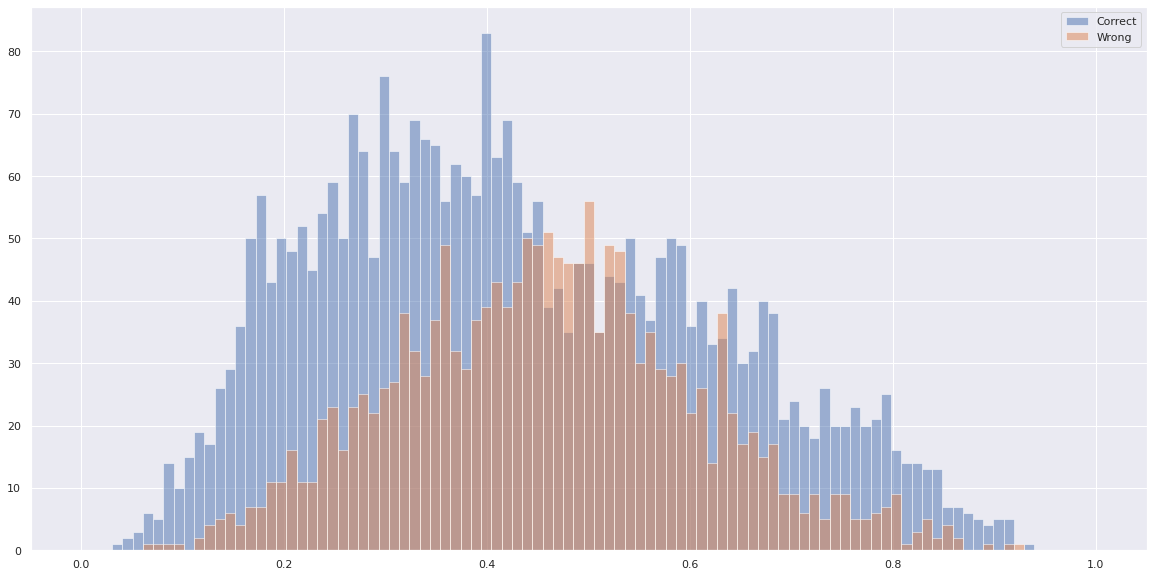

In [49]:
pred_prob_winner = clf.predict_proba(X)
x = pred_prob_winner[np.where(Y == pred_winner),0].T
y = pred_prob_winner[np.where(Y != pred_winner),0].T

bins = np.linspace(0, 1, 100)

c = plt.hist(x, bins, alpha=0.5, label='Correct')
w = plt.hist(y, bins, alpha=0.5, label='Wrong')
plt.legend(loc='upper right')
plt.show()

/tmp/ipykernel_42310/2333336800.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.linspace(0, 1, 99),c[0]/(c[0]+w[0]))


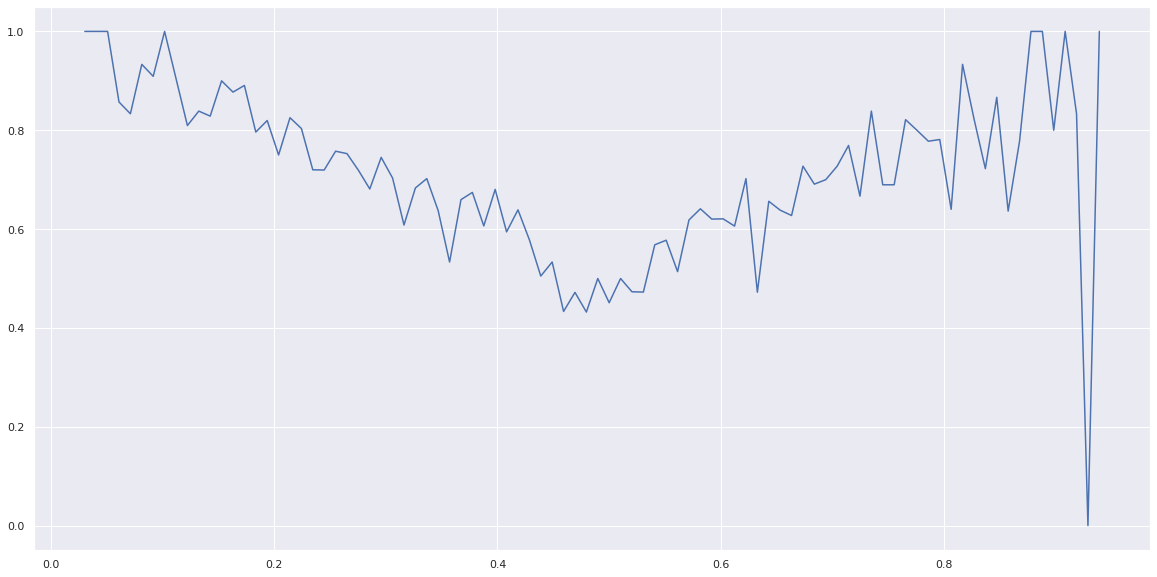

In [50]:
plt.plot(np.linspace(0, 1, 99),c[0]/(c[0]+w[0]))

In [51]:
np.shape(y)

(1693, 1)

In [52]:
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in np.concatenate((np.arange(1,self.MaxVars+1),np.arange(self.nCols-self.MaxVars+2,self.nCols))): 
            #for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

In [53]:
result = BMA(Y, X, RegType = 'Logit', Verbose=True, MaxVars=3).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 1.9347293383037629974028101201637003261579714817212e-1449
Model Variables: (1,) rejected by Occam's window
Model Variables: (2,) likelihood= 8.9132602422617447264927791396665364445411065388525e-1446
Model Variables: (3,) rejected by Occam's window
Model Variables: (4,) likelihood= 4.4166665901909172574445792758062607039059525120744e-1446
Model Variables: (5,) rejected by Occam's window
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) rejected by Occam's window
Model Variables: (8,) likelihood= 5.171918883490346828694398298493650165310764176901e-1446
Model Variables: (9,) rejected by Occam's window
Model Variables: (10,) likelihood= 1.2639771158903911043444005473044743973509726777748e-1446
Model Variables: (11,) rejected by Occam's window
Model Variables: (12,) likelihood= 6.7961800344961871480583625138987998087944500863339e-1446
Model Variables: (13,) likelihood= 3.03666211257843139148813228009

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window


/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Variables: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120] rejected by Occam's window
Model Variables: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
print(result.summary().sort_values('Probability').iloc[-50:])

                         Variable Name Probability Avg. Coefficient
49               pressures_opp_homeAvg     0.00029         0.000007
71             total_yards_opp_awayAvg    0.000377              0.0
31                   score_opp_homeAvg    0.000394         0.000006
32                       score_homeAvg    0.000394         0.000006
6                 fourth_downs_homeAvg    0.000503         0.000061
1              first_downs_opp_homeAvg    0.000512         0.000009
22                   turnovers_homeAvg    0.000553         0.000122
5             fourth_downs_opp_homeAvg    0.000589          0.00007
11             total_yards_opp_homeAvg    0.000611         0.000001
69           rushing_yards_opp_awayAvg    0.000651         0.000002
64                 third_downs_awayAvg    0.000652         0.000044
13                   sacks_opp_homeAvg    0.000679         0.000102
40   fourth_downs_attempts_opp_homeAvg    0.000802         0.000039
8                passing_yards_homeAvg    0.0008

In [55]:
# predict the y-values from training input data
pred_BMA = result.predict(X)

In [56]:
# compute accuracy
print("BMA Accuracy: ", np.sum((pred_BMA > 0.5) == Y)/len(Y))

BMA Accuracy:  0.6380481778875849


In [57]:
Y = df1['score_diff'].iloc[200:]
# make a linear regreesion model to predict the hom team score
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

pred_score_diff = results.predict(X)
print('RMS:')
print(np.sqrt(np.mean((pred_score_diff-Y)**2)))
sns.regplot(pred_score_diff,Y, marker="+",scatter_kws={'alpha':0.5});

ValueError: The indices for endog and exog are not aligned

In [ ]:
print('Prediciton Accuracy:')
np.sum(pred_score_diff*Y > 0)/len(Y)